#### Contents
- [The fundamental traffic diagram](#the-fundamental-traffic-diagram)
- [Spatial analysis](#spatial-analysis)
- [Lane transitions](#lane-transitions)
- [Predicting models](#predicting-models)
- [Extreme events](#extreme-events)

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [43]:
import os, sys, time, datetime, random
from pathlib import Path
from warnings import warn
from tqdm import tqdm, tnrange, tqdm_notebook
import pickle as pkl
import gc

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import BasicProcessor as bp

In [4]:
if '../Tracker' not in sys.path: sys.path.append('../Tracker')
import Tracker as t

In [5]:
mpl.rcParams.update({'font.size': 14})

## Load data

In [7]:
df, sf = bp.load_data_summary()
df.shape, sf.shape

((82091, 78), (186746, 104))

In [8]:
vf = pd.read_csv(r'../Photographer/videos_metadata.csv', index_col=0)
vf

,video,size_mb,len_minutes,date,time,weekday
20190520_105429.mp4,20190520_105429.mp4,115.474790,7.231111,20190520,10.908056,2
20190520_112342.mp4,20190520_112342.mp4,522.146511,32.755556,20190520,11.395000,2
20190520_141707.mp4,20190520_141707.mp4,129.201198,8.102222,20190520,14.285278,2
20190520_151643.mp4,20190520_151643.mp4,134.681172,8.435556,20190520,15.278611,2
20190520_171559.mp4,20190520_171559.mp4,166.763672,10.453333,20190520,17.266389,2
...,...,...,...,...,...,...
20190703_193828_protest.2.mp4,20190703_193828_protest.2.mp4,84.800777,5.320000,20190703,19.641111,4
20190705_085717_parking.enter.queue.mp4,20190705_085717_parking.enter.queue.mp4,97.129501,6.088889,20190705,8.954722,6
20190705_101321.mp4,20190705_101321.mp4,105.950683,6.644444,20190705,10.222500,6
20190706_005745.mp4,20190706_005745.mp4,169.395233,10.626667,20190706,0.962500,7


In [9]:
nf = bp.detections_count()
nf.head()

,video,n_frames,n_detections,detections_per_frame,n_detections_sd
20190520_105429,20190520_105429,1627,28986,17.8156,8.160223
20190520_112342,20190520_112342,7370,87822,11.9161,2.973200
20190520_141707,20190520_141707,1823,41040,22.5123,5.383049
20190520_151643,20190520_151643,1898,61264,32.2782,4.186581
20190520_171559,20190520_171559,2352,37159,15.7989,3.676079
...,...,...,...,...,...
20190703_193828_protest.2,20190703_193828_protest.2,1197,5729,4.78613,2.158554
20190705_085717_parking.enter.queue,20190705_085717_parking.enter.queue,1370,11195,8.17153,2.461186
20190705_101321,20190705_101321,1495,13200,8.82943,2.672229
20190706_005745,20190706_005745,2391,6505,2.72062,1.887175


## The fundamental traffic diagram

In [104]:
# Speed per video - averaged over frames (not cars) - giving larger weight to (slow) cars with many frames...
n_per_line = bp.get_cols(sf, 'n', spatial=True, return_data=True).iloc[:,1:]
v_per_line = bp.get_cols(sf, 'v', spatial=True, return_data=True)

n_per_line.columns = np.arange(n_per_line.shape[1])
v_per_line.columns = np.arange(n_per_line.shape[1])

v_per_frame = (n_per_line*v_per_line).sum(axis=1, skipna=True) / (n_per_line).sum(axis=1, skipna=True)

v_per_video = 3.6*pd.DataFrame({'video':sf.video, 'v':v_per_frame}).groupby('video')['v'].apply(np.mean)

n_lanes = 5
road_len = df.max_x.max()-0 # (min_x has some weird outlier)

avg_speeds = 3.6*df.groupby('video')['abs_v'].apply(np.mean)
detections_per_10m = nf.detections_per_frame / (n_lanes*road_len/10)
flux = df.groupby('video')['abs_v'].apply(len) / vf.len_minutes

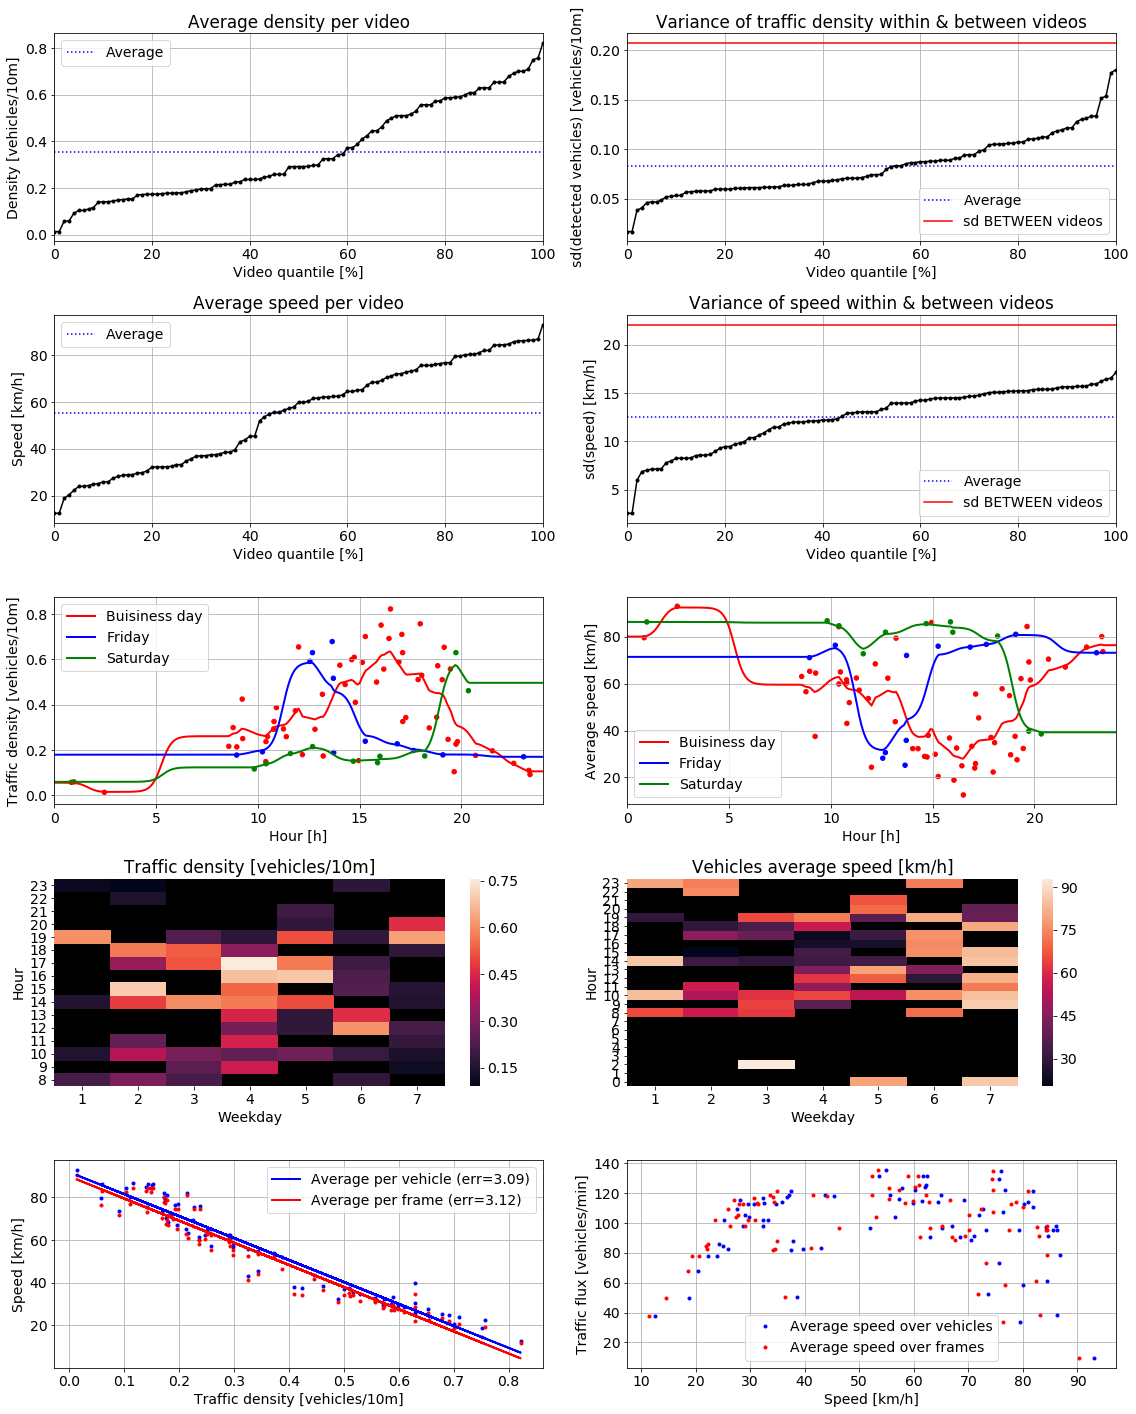

In [128]:
_, axs = plt.subplots(5,2, figsize=(16,20))

# vehicles per frame
ax = axs[0,0]
t.qplot(detections_per_10m, xlab='Video', ylab='Density [vehicles/10m]', ax=ax)
ax.set_title('Average density per video')

ax = axs[0,1]
t.qplot(nf.n_detections_sd / (n_lanes*road_len/10), xlab='Video', ylab='sd(detected vehicles) [vehicles/10m]', ax=ax)
ax.axhline(detections_per_10m.std(),
           color='r', label='sd BETWEEN videos')
ax.set_title('Variance of traffic density within & between videos')
ax.legend()

# speed distribution
ax = axs[1,0]
t.qplot(avg_speeds, xlab='Video', ylab='Speed [km/h]', ax=ax)
ax.set_title('Average speed per video')

ax = axs[1,1]
t.qplot(3.6*df.groupby('video')['abs_v'].apply(np.std), xlab='Video', ylab='sd(speed) [km/h]', ax=ax)
ax.axhline(avg_speeds.std(), color='r', label='sd BETWEEN videos')
ax.set_title('Variance of speed within & between videos')
ax.legend()

# info vs time by day
ax = axs[2,0]
ax.scatter(vf.time, detections_per_10m, s=20, c=['red' if day<=5 else 'blue' if day==6 else 'green' for day in vf.weekday])
hours = np.arange(0,24.01,0.1)
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values<=5].time, detections_per_10m[vf.weekday.values<=5], 0.5),
        'r-', linewidth=2, label='Buisiness day')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==6].time, detections_per_10m[vf.weekday.values==6], 0.5),
        'b-', linewidth=2, label='Friday')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==7].time, detections_per_10m[vf.weekday.values==7], 0.5),
        'g-', linewidth=2, label='Saturday')
ax.set_xlim((0,24))
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Traffic density [vehicles/10m]')
ax.grid()
ax.legend()

ax = axs[2,1]
ax.scatter(vf.time, avg_speeds, s=20, c=['red' if day<=5 else 'blue' if day==6 else 'green' for day in vf.weekday])
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values<=5].time, avg_speeds[vf.weekday.values<=5], 0.5),
        'r-', linewidth=2, label='Buisiness day')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==6].time, avg_speeds[vf.weekday.values==6], 0.5),
        'b-', linewidth=2, label='Friday')
ax.plot(hours, bp.rolling(hours, vf[vf.weekday.values==7].time, avg_speeds[vf.weekday.values==7], 0.5),
        'g-', linewidth=2, label='Saturday')
ax.set_xlim((0,24))
ax.set_xlabel('Hour [h]')
ax.set_ylabel('Average speed [km/h]')
ax.grid()
ax.legend()

# info per time & day
ax = axs[3,0]
mean_or_nan = lambda x: np.mean(x) if len(x)>0 else np.nan
dets_hm = np.array([[mean_or_nan(detections_per_10m.values[np.logical_and(vf.weekday==day,np.floor(vf.time)==hour)])
                     for day in np.arange(1,8)] for hour in np.arange(8,24)])
sns.heatmap(dets_hm, xticklabels=np.arange(1,8,dtype=int), yticklabels=np.arange(8,24,dtype=int), ax=ax)
ax.invert_yaxis()
ax.set_facecolor("black")
ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_title('Traffic density [vehicles/10m]')

ax = axs[3,1]
speed_hm = np.array([[mean_or_nan(avg_speeds.values[np.logical_and(vf.weekday==day,np.floor(vf.time)==hour)])
                     for day in np.arange(1,8)] for hour in np.arange(24)])
sns.heatmap(speed_hm, xticklabels=np.arange(1,8,dtype=int), yticklabels=np.arange(24,dtype=int), ax=ax)
ax.invert_yaxis()
ax.set_facecolor("black")
ax.set_xlabel('Weekday')
ax.set_ylabel('Hour')
ax.set_title('Vehicles average speed [km/h]')

# the fundamental traffic diagram
ax = axs[4,0]
ax.plot(detections_per_10m, avg_speeds, 'b.')
ax.plot(detections_per_10m, v_per_video, 'r.')
slope, intercept, _, _, std_err = stats.linregress(detections_per_10m.astype(float), avg_speeds)
preds = intercept + slope * detections_per_10m
ax.plot(detections_per_10m, preds, 'b-', linewidth=2, label=f'Average per vehicle (err={std_err:.2f})')
slope, intercept, _, _, std_err = stats.linregress(detections_per_10m.astype(float), v_per_video)
preds = intercept + slope * detections_per_10m
ax.plot(detections_per_10m, preds, 'r-', linewidth=2, label=f'Average per frame (err={std_err:.2f})')
ax.set_xlabel('Traffic density [vehicles/10m]')
ax.set_ylabel('Speed [km/h]')
ax.grid()
ax.legend()

ax = axs[4,1]
ax.plot(avg_speeds, flux, 'b.', label='Average speed over vehicles')
ax.plot(v_per_video, flux, 'r.', label='Average speed over frames')
ax.set_xlabel('Speed [km/h]')
ax.set_ylabel('Traffic flux [vehicles/min]')
ax.grid()
ax.legend()

plt.tight_layout()

#### TODO
The outlier of the traffic diagram (speed vs. density) is the 25/5/19, where there was a single dense line in the right.
1. That's a video with fascinate dynamics that should be studied.
2. The average speed is large since most cars are fast and appear briefly. The density is large since the few slow cars stay forever.
    - V plot average speed per frame and not per car (the traffic diagram apparently assumes homogenuous speed).
    - TODO think about a model for the heterogeneuous case (or direct reduction to the homogeneuous case?).
    
Meanwhile, the 2nd diagram looks way noisier.
    - TODO verify the flux is correct (that it comes from the right origin and that both n_cars/minutes components are synced).
    - TODO add flux vs. density
    - TODO look at outliers
    - TODO compare to theory of the fundamental traffic diagram

## Spatial analysis

TODO
    - speed & density vs. lanes & road-part (heatmaps, boxplots)

## Lane transitions

TODO
    - when do lane transitions occur (lanes; road densities/speeds)?
    - which drivers move lanes (absolute & relative speed)?
    - are lane transitions helpful (speed before & after, bucketed by lane and/or direction)?
    - externalities (speeds around before & after)

## Predicting models

TODO
    - based on speeds at lanes 1-5 at x=20, predict speeds of the same cars at at lanes 1-5 at x=80 (i.e. 60m/mean(v) seconds later). try linear and maybe trees with additional properties. the naive result would be beta=1 for the same lane and 0 otherwise. anything else may be exploitable.
    - ARIMA seasonal model for traffic speed/density over time within/between videos? sounds difficult.

## Extreme events

TODO
    - look for accidents (low-speed outlier within a video) - probably wont find anything
    - look for large speed differences between x's (sudden stop/acceleration) or lanes (few-lanes congestion)

#### Fastest & slowest vehicles

3.917459684862539 142.58894229381357


,car,video_group,video,vid_len,date,time,weekday,n_shots,consistent_xy_nas,continuous_track,...,lane_26,lane_32,lane_38,lane_44,lane_50,lane_56,lane_62,lane_68,lane_74,lane_80
19328,26,1,20190525_194340.mp4,6.013333,20190525,19.727778,7,265,True,False,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9370,985,1,20190520_232200.mp4,12.577778,20190520,23.366667,2,8,True,True,...,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,NaN


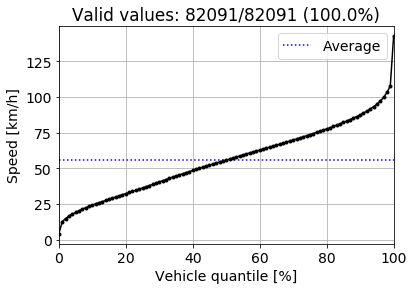

In [119]:
t.qplot(3.6*df.v, xlab='Vehicle', ylab='Speed [km/h]')
slowest = df.loc[df.v.idxmin(),'car']
fastest = df.loc[df.v.idxmax(),'car']
print(3.6*df.v.min(), 3.6*df.v.max())
df.iloc[[df.v.idxmin(), df.v.idxmax()], :]

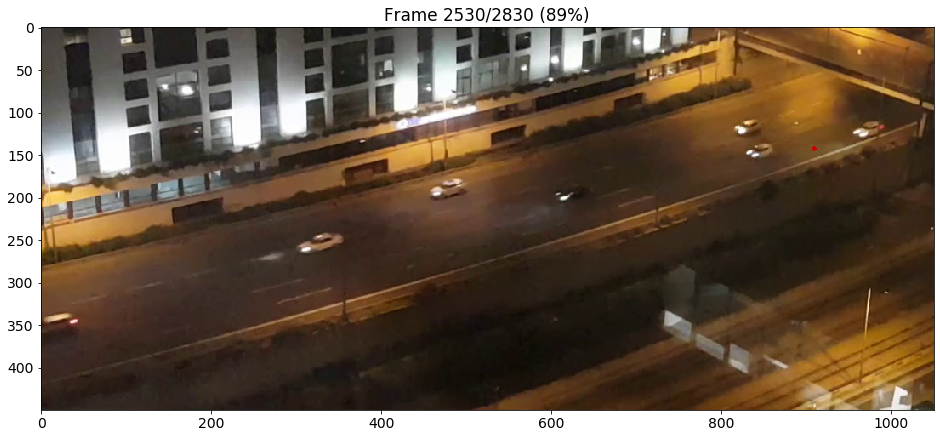

In [310]:
bp.show_car('20190520_232200', 985, display=1, dots=False, self_track=1, extra_frames=2, save_video='fastest_car_11pm_143kmh')

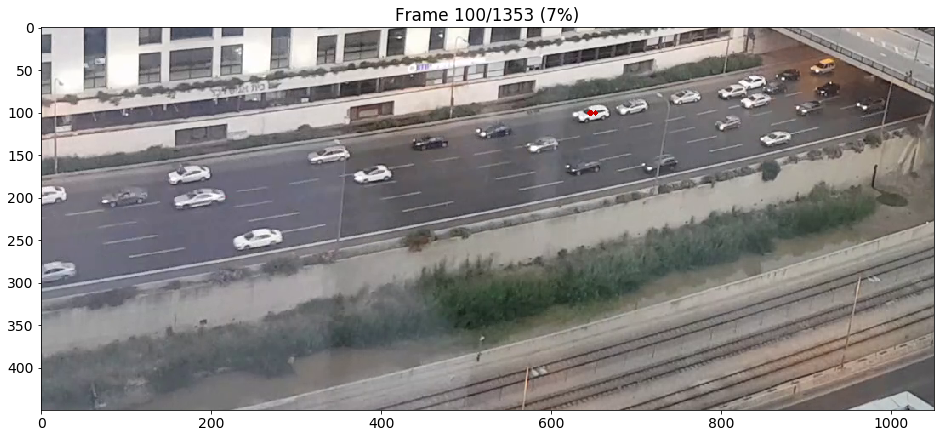

In [336]:
# slowest
# consider saving video with skipped frames or larger frame rate
bp.show_car('20190525_194340', 26, display=1, dots=False, self_track=1, goal_frame=100,
            save_video='../Analysis/slowest_car_1943pm_3.9kmh', save_frame='../Analysis/slowest_car_1943pm_3.9kmh')

#### Most & least dense frames

In [316]:
videos = bp.get_all_videos()
dense = (None, None, 0)
sparse = (None, None, np.inf)
for video in videos:
    with open(bp.DATA_DIR/f'{video:s}.pkl', 'rb') as f:
        N = pkl.load(f)['N']
        if N.max() > dense[2]:
            dense = (video, N.argmax(), N.max())
        if N.min() < sparse[2]:
            sparse = (video, N.argmin(), N.min())
sparse, dense

(('20190520_232200', 22, 0.0), ('20190612_175832', 105, 54.0))

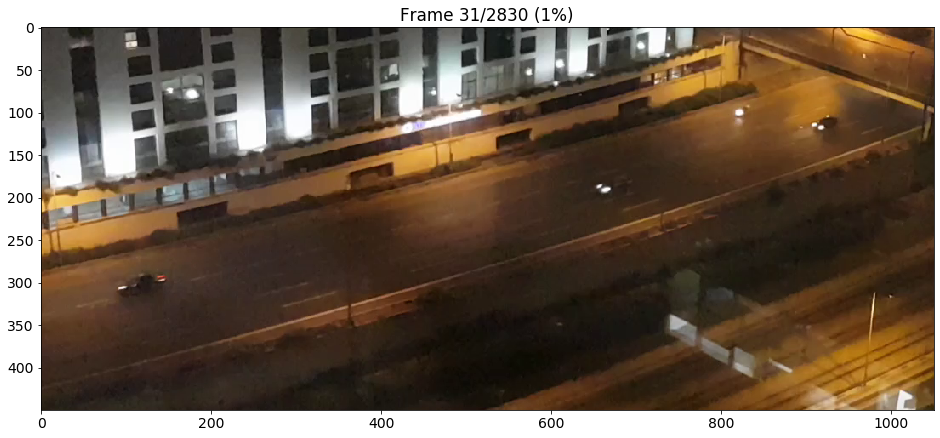

In [328]:
# Sparse
bp.show_car('20190520_232200', 9, display=2, self_track=0, goal_frame=28, extra_frames=-8, dots=False,
            save_video='../Analysis/Sparse_road_11pm', save_frame='../Analysis/Sparse_road_11pm')

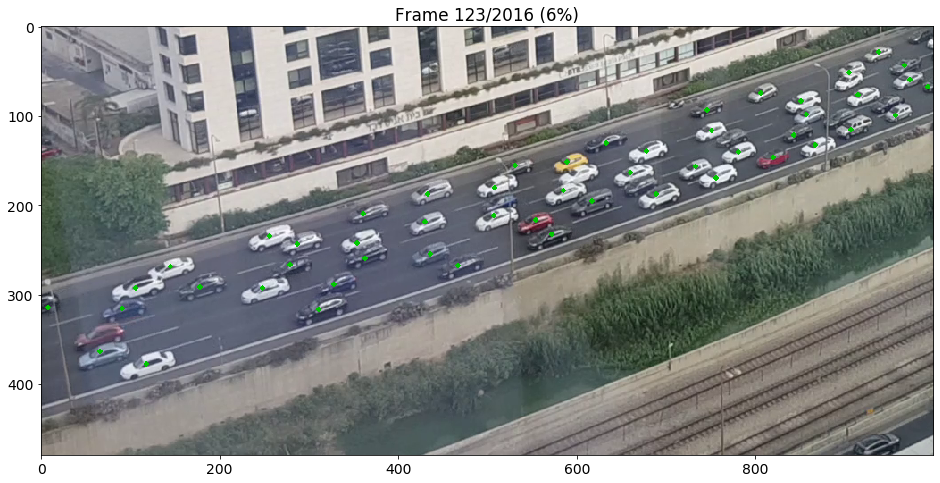

In [330]:
# Dense
bp.show_car('20190612_175832', 190, display=1, self_track=0, dots=0, all_detections=True,
            save_frame='../Analysis/Dense_road_6pm')

## TMP New figures infra

In [8]:
vf['group'] = vf.video>'20190525'

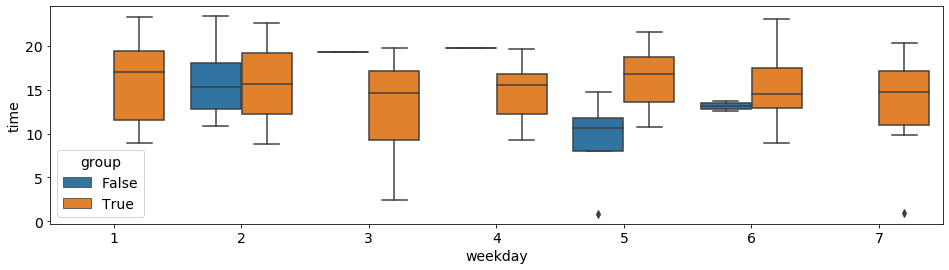

In [20]:
plt.figure(figsize=(16,4))
sns.boxplot(data=vf, x='weekday', y='time', hue='group')#, notch=True)

In [25]:
list(set(vf.columns)-set('date'))
# vf.columns

['time', 'date', 'size_mb', 'group', 'len_minutes', 'video', 'weekday']

D:\Code\Python\Ayalon\Analyzer\BasicProcessor.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[fac_name] = fac
D:\Code\Python\Ayalon\Analyzer\BasicProcessor.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d[val_name] = df[c]


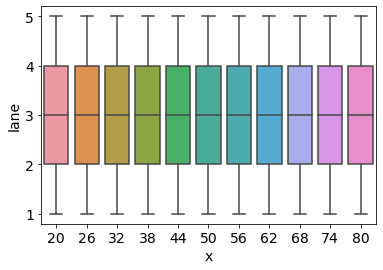

In [35]:
sns.boxplot('x','lane', data=bp.agg_df(df, bp.get_cols(df, 'lane'), cols_to_keep=[], fac_name='x', val_name='lane', factors=bp.X_REF))

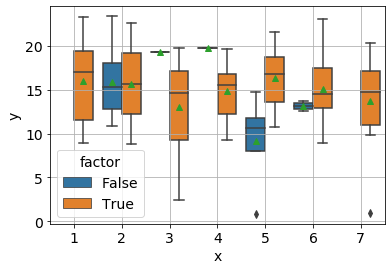

In [41]:
bp.boxplot(vf.weekday, vf.time, vf.group)

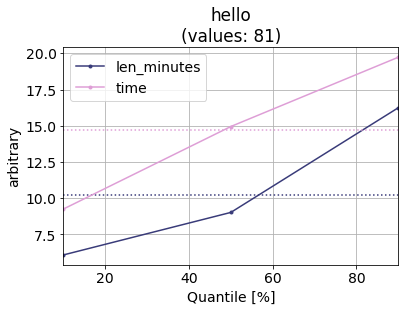

In [61]:
bp.qplots(vf[['len_minutes','time']], (10,50,90), 'arbitrary', 'hello', True, remove_na_rows=False)